# TFM

##1. Configuacion

In [1]:
# Instalación de librerías necesarias
!pip install pyeph > /dev/null 2>&1
!pip install scikit-learn openpyxl > /dev/null 2>&1

In [2]:
# Importación de librerías
import pyeph
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

##2. Extraer bases de datos
Se utiliza la libreria [pyeph](https://pypi.org/project/pyeph/)

In [3]:
# ----------------------------------------------------------------------
# Descarga y carga de datos EPH
# ----------------------------------------------------------------------

bases_individuales = {}
bases_hogar = {}

for ano in range(2023, 2024):
    for trimestre in range(1, 5):
        clave = f"{ano}T{trimestre}"
        try:
            bases_individuales[clave] = pyeph.obtener(data="eph", ano=ano, periodo=trimestre, tipo_base="individual")
            print(f"✓ Base individual {clave} descargada")
        except Exception as e:
            print(f"✗ Error en base individual {clave}: {e}")

        try:
            bases_hogar[clave] = pyeph.obtener(data="eph", ano=ano, periodo=trimestre, tipo_base="hogar")
            print(f"✓ Base hogar {clave} descargada")
        except Exception as e:
            print(f"✗ Error en base hogar {clave}: {e}")

Obtenido con exito: base_individual_2023T1.zip 
✓ Base individual 2023T1 descargada
Obtenido con exito: base_hogar_2023T1.zip 
✓ Base hogar 2023T1 descargada
Obtenido con exito: base_individual_2023T2.zip 
✓ Base individual 2023T2 descargada
Obtenido con exito: base_hogar_2023T2.zip 
✓ Base hogar 2023T2 descargada
Obtenido con exito: base_individual_2023T3.zip 
✓ Base individual 2023T3 descargada
Obtenido con exito: base_hogar_2023T3.zip 
✓ Base hogar 2023T3 descargada
Obtenido con exito: base_individual_2023T4.zip 
✓ Base individual 2023T4 descargada
Obtenido con exito: base_hogar_2023T4.zip 
✓ Base hogar 2023T4 descargada


In [4]:
# ----------------------------------------------------------------------
# Exportar a Excel las bases del 4º trimestre 2023
# ----------------------------------------------------------------------

clave_exportar = "2023T4"

# Exportar base individual
df_individual_export = bases_individuales[clave_exportar].copy()
df_individual_export.to_excel(f"base_individual_{clave_exportar}.xlsx", index=False)

# Exportar base hogar
df_hogar_export = bases_hogar[clave_exportar].copy()
df_hogar_export.to_excel(f"base_hogar_{clave_exportar}.xlsx", index=False)

##3. Procesar datos

###3.1 Crear bases

In [5]:
# ----------------------------------------------------------------------
# Procesamiento base HOGAR (4° trimestre 2023)
# ----------------------------------------------------------------------

clave = "2023T4"

variables_hogar_interes = [
    'CODUSU', 'NRO_HOGAR', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO',
    'PONDERA', 'PONDIH', 'IX_TOT', 'IPCF',
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11',
    'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

variables_filtradas = [
    'CODUSU', 'PONDERA', 'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7',
    'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'IX_TOT', 'IPCF', 'PONDIH',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

df_hogar = bases_hogar[clave][variables_hogar_interes].copy()
df_hogar = df_hogar[variables_filtradas].copy()

# Corrección decimal en IPCF
df_hogar['IPCF'] = pd.to_numeric(df_hogar['IPCF'].astype(str).str.replace(",", "."), errors='coerce')

# Reemplazo de valores especiales en VII*
variables_vii = ['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']
df_hogar[variables_vii] = df_hogar[variables_vii].replace(0, 98)

# Conversión general a numérico (menos CODUSU)
for col in df_hogar.columns:
    if col != 'CODUSU':
        df_hogar[col] = pd.to_numeric(df_hogar[col], errors='coerce')

# Rangos válidos (valores permitidos)
rangos_validos = {
    'IV1': (1, 5), 'IV2': (1, 10), 'IV3': (1, 3), 'IV4': (1, 9), 'IV5': (1, 2),
    'IV6': (1, 3), 'IV7': (1, 3), 'IV8': (1, 2), 'IV9': (1, 3), 'IV10': (1, 3), 'IV11': (1, 4),
    'IV12_1': (1, 2), 'IV12_2': (1, 2), 'IV12_3': (1, 2),
    'II1': (1, 10), 'II2': (1, 10), 'II3': (1, 2), 'II4_1': (1, 2), 'II4_2': (1, 2), 'II4_3': (1, 2),
    'II7': (1, 8), 'II8': (1, 3), 'II9': (1, 4),
    'V1': (1, 2), 'V2': (1, 2), 'V7': (1, 2), 'V8': (1, 2), 'V9': (1, 2), 'V10': (1, 2),
    'V19_A': (1, 2), 'V19_B': (1, 2), 'IX_TOT': (1, 20), 'IPCF': (0, 5000001),
    'VII1_1': (1, 50), 'VII1_2': (1, 50), 'VII2_1': (1, 50), 'VII2_2': (1, 50),
    'VII2_3': (1, 50), 'VII2_4': (1, 50)
}

valores_extra_vii = [96, 97, 98]

# Filtro por rangos válidos
for var, (min_val, max_val) in rangos_validos.items():
    if var in variables_vii:
        df_hogar = df_hogar[df_hogar[var].isin(list(range(min_val, max_val + 1)) + valores_extra_vii)]
    else:
        df_hogar = df_hogar[(df_hogar[var] >= min_val) & (df_hogar[var] <= max_val)]

# Exportar base hogar
df_hogar.to_excel("df_hogar_2023T4.xlsx", index=False)

df_hogar

,CODUSU,PONDERA,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,...,V19_B,IX_TOT,IPCF,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORSQHKMKUCDEIGED00791045,107,1,4,1,1,1,1,1,1,...,2,3,283333.33,128,1,98,98,98,98,98
1,TQRMNOPVSHJMLNCDEIGED00801502,137,1,3,1,1,2,1,1,1,...,2,2,0.00,0,1,98,2,98,98,98
2,TQRMNORTYHMLKPCDEHJGH00810920,356,2,4,1,9,1,1,1,1,...,2,4,192500.00,329,2,98,1,98,98,98
3,TQRMNOQTWHKLKQCDEHJGH00790284,299,1,6,1,3,1,1,1,1,...,2,3,33333.33,320,1,98,2,98,98,98
4,TQRMNORQVHLLKRCDEHJGH00853836,221,1,5,1,2,1,1,1,1,...,2,2,150000.00,193,1,98,96,98,98,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16456,TQRMNOSXVHKMLMCDEFMDB00787973,180,1,4,1,1,1,1,1,1,...,2,4,30000.00,322,1,98,2,3,4,98
16457,TQRMNOQQYHLOLMCDEFMDB00852214,170,2,3,1,1,1,1,1,1,...,2,2,0.00,0,2,98,98,98,98,98
16458,TQRMNOUQYHLOLNCDEFMDB00852215,249,1,2,1,4,2,1,1,1,...,2,3,0.00,0,1,98,98,98,98,98
16460,TQRMNOSXQHJMKQCDEGKDB00794419,92,1,5,1,4,1,1,1,1,...,2,12,0.00,0,1,7,8,3,98,98


In [6]:
# ----------------------------------------------------------------------
# Procesamiento base INDIVIDUAL (4° trimestre 2023)
# ----------------------------------------------------------------------

variables_individuo = [
    'CODUSU', 'COMPONENTE', 'PONDERA',
    'CH04', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10',
    'CH11', 'CH12', 'CH13', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC'
]

df_ind = bases_individuales[clave][variables_individuo].copy()
df_ind['CH11'] = df_ind['CH11'].replace(0, 9)
df_ind['CH12'] = df_ind['CH12'].replace(0, 1)

rangos_validos_ind = {
    'COMPONENTE': (1, 20), 'CH04': (1, 2), 'CH06': (0, 105),
    'CH07': (1, 5), 'CH08': [1, 2, 3, 4, 9, 12, 13, 23, 123],
    'CH09': (1, 3), 'CH10': (1, 3), 'CH11': [1, 2, 9],
    'CH12': (1, 9), 'CH13': (0, 2), 'NIVEL_ED': (1, 7),
    'ESTADO': (1, 4), 'CAT_OCUP': (0, 4), 'CAT_INAC': (0, 7)
}

for var, criterio in rangos_validos_ind.items():
    if isinstance(criterio, tuple):
        df_ind = df_ind[(df_ind[var] >= criterio[0]) & (df_ind[var] <= criterio[1])]
    elif isinstance(criterio, list):
        df_ind = df_ind[df_ind[var].isin(criterio)]

# ----------------------------------------------------------------------
# Cálculo de variables educativas: EDA_ESC, EDA_ESP, IEAE
# ----------------------------------------------------------------------

# Años de escolaridad alcanzados según NIVEL_ED
mapa_eda_esc = {
    7: 5,
    1: 8.5,
    2: 12,
    3: 14.5,
    4: 17,
    5: 19,
    6: 21
}
df_ind['EDA_ESC'] = df_ind['NIVEL_ED'].map(mapa_eda_esc)

# Años de escolaridad esperados según edad (CH06)
df_ind['EDA_ESP'] = np.select(
    [
        df_ind['CH06'] <= 5,
        df_ind['CH06'] >= 22
    ],
    [
        5,
        22
    ],
    default=df_ind['CH06']
)

# Índice Educativo Ajustado por Edad
df_ind['IEAE'] = df_ind['EDA_ESC'] / df_ind['EDA_ESP']
df_ind['IEAE'] = df_ind['IEAE'].clip(upper=1)

# Exportar base hogar

df_ind.to_excel("df_individual_2023T4.xlsx", index=False)

df_ind

,CODUSU,COMPONENTE,PONDERA,CH04,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,EDA_ESC,EDA_ESP,IEAE
0,TQRMNOSUWHLMKQCDEFNFF00852219,1,370,1,60,2,1,1,2,9,7,1,6,1,3,0,21.0,22,0.954545
1,TQRMNOSUWHLMKQCDEFNFF00852219,2,370,2,52,2,1,1,2,9,4,1,4,3,0,4,17.0,22,0.772727
2,TQRMNOTXQHKOLMCDEGNFJ00794590,1,281,1,34,1,1,1,2,9,4,1,4,1,3,0,17.0,22,0.772727
3,TQRMNOTXQHKOLMCDEGNFJ00794590,2,281,2,32,1,1,1,2,9,4,1,4,1,3,0,17.0,22,0.772727
4,TQRMNOTXQHKOLMCDEGNFJ00794590,3,281,2,6,5,1,1,1,1,2,2,1,4,0,3,8.5,6,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47332,TQRMNORXTHLOLSCDEGJBF00853031,1,634,1,80,1,1,2,2,9,2,2,1,3,0,7,8.5,22,0.386364
47333,TQRMNORXTHLOLSCDEGJBF00853031,2,634,2,47,5,1,1,2,9,4,1,4,1,3,0,17.0,22,0.772727
47334,TQRMNORXTHLOLSCDEGJBF00853031,3,634,1,42,5,4,1,2,9,2,2,1,1,2,0,8.5,22,0.386364
47335,TQRMNORXTHLOLSCDEGJBF00853031,4,634,2,58,1,4,1,2,9,2,2,1,3,0,7,8.5,22,0.386364


###3.2 Conformacion base de interes

In [7]:
# ----------------------------------------------------------------------
# Construcción de base final para estimaciones (hogar + indicadores)
# ----------------------------------------------------------------------

# 1. Hacinamiento: IX_TOT / II2
df_hogar['HAC'] = df_hogar['IX_TOT'] / df_hogar['II2']

# 2-7. Indicadores a nivel hogar desde base individual
df_ind_agg = df_ind.groupby('CODUSU').agg(
    EDA_sum=('CH06', 'sum'),
    FEM_sum=('CH04', lambda x: (x == 2).sum()),
    ANALFABET_sum=('CH09', lambda x: (x == 2).sum()),
    DESOCUP_sum=('ESTADO', lambda x: (x == 2).sum()),
    INACTIVOS_sum=('ESTADO', lambda x: (x == 3).sum()),
    IEAE_sum=('IEAE', 'sum')
).reset_index()

# Unir con base hogar
df_modelo = df_hogar.merge(df_ind_agg, on='CODUSU', how='inner')

# Calcular proporciones normalizadas por IX_TOT
df_modelo['EDA'] = df_modelo['EDA_sum'] / df_modelo['IX_TOT']
df_modelo['FEM'] = df_modelo['FEM_sum'] / df_modelo['IX_TOT']
df_modelo['ANALFABET'] = df_modelo['ANALFABET_sum'] / df_modelo['IX_TOT']
df_modelo['DESOCUP'] = df_modelo['DESOCUP_sum'] / df_modelo['IX_TOT']
df_modelo['INACTIVOS'] = df_modelo['INACTIVOS_sum'] / df_modelo['IX_TOT']
df_modelo['NE'] = df_modelo['IEAE_sum'] / df_modelo['IX_TOT']

# Exportar base final
df_modelo.to_excel("df_modelo_estimaciones_2023T4.xlsx", index=False)

# Vista previa
df_modelo

,CODUSU,PONDERA,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,...,ANALFABET_sum,DESOCUP_sum,INACTIVOS_sum,IEAE_sum,EDA,FEM,ANALFABET,DESOCUP,INACTIVOS,NE
0,TQRMNORSQHKMKUCDEIGED00791045,107,1,4,1,1,1,1,1,1,...,0,0,1,2.954545,18.666667,1.000000,0.000000,0.000000,0.333333,0.984848
1,TQRMNOPVSHJMLNCDEIGED00801502,137,1,3,1,1,2,1,1,1,...,0,0,2,1.727273,67.500000,0.500000,0.000000,0.000000,1.000000,0.863636
2,TQRMNORTYHMLKPCDEHJGH00810920,356,2,4,1,9,1,1,1,1,...,0,0,0,2.762626,21.250000,0.500000,0.000000,0.000000,0.000000,0.690657
3,TQRMNOQTWHKLKQCDEHJGH00790284,299,1,6,1,3,1,1,1,1,...,0,1,0,1.818182,26.666667,0.333333,0.000000,0.333333,0.000000,0.606061
4,TQRMNORQVHLLKRCDEHJGH00853836,221,1,5,1,2,1,1,1,1,...,0,0,1,1.860795,31.500000,1.000000,0.000000,0.000000,0.500000,0.930398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,TQRMNOSXVHKMLMCDEFMDB00787973,180,1,4,1,1,1,1,1,1,...,0,2,2,3.386364,31.750000,0.750000,0.000000,0.500000,0.500000,0.846591
16034,TQRMNOQQYHLOLMCDEFMDB00852214,170,2,3,1,1,1,1,1,1,...,0,0,1,1.090909,73.500000,0.500000,0.000000,0.000000,0.500000,0.545455
16035,TQRMNOUQYHLOLNCDEFMDB00852215,249,1,2,1,4,2,1,1,1,...,0,0,0,2.213203,43.666667,0.666667,0.000000,0.000000,0.000000,0.737734
16036,TQRMNOSXQHJMKQCDEGKDB00794419,92,1,5,1,4,1,1,1,1,...,1,0,4,8.805240,27.916667,0.500000,0.083333,0.000000,0.333333,0.733770


##4. Regresion
$${NE}_i = f(X_i) + e_i$$

###4.1 MCO con seleccion de variables

In [8]:
# -------------------------------
# 1. Preparar X e y
# -------------------------------
excluded_cols = [
    'NE', 'PONDERA', 'PONDIH', 'EDA_sum', 'FEM_sum',
    'ANALFABET_sum', 'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum'
]
X = df_modelo.drop(columns=excluded_cols, errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df_modelo['NE']

# -------------------------------
# 2. Dividir en entrenamiento/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# -------------------------------
# 3. Definir modelos
# -------------------------------
modelos = {
    'Lasso': ('lassocv', make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=0))),
    'Ridge': ('ridgecv', make_pipeline(StandardScaler(), RidgeCV(cv=5))),
    'ElasticNet': ('elasticnetcv', make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=0)))
}

# -------------------------------
# 4. Ajuste, predicción y evaluación
# -------------------------------
resultados = []

for nombre, (etiqueta, modelo) in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    resultados.append({
        'Modelo': nombre,
        'R2': r2,
        'RMSE': rmse
    })

# -------------------------------
# 5. Mostrar resultados
# -------------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

       Modelo        R2      RMSE
0       Lasso  0.391988  0.184350
1       Ridge  0.392089  0.184335
2  ElasticNet  0.391950  0.184356


###4.2 Bosques aleatorios

In [9]:
# -------------------------------
# 6. Random Forest Regressor
# -------------------------------

# Crear modelo
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0)

# Ajustar
rf_model.fit(X_train, y_train)

# Predecir
y_pred_rf = rf_model.predict(X_test)

# Evaluar
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Agregar resultados a la tabla
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'RandomForest', 'R2': r2_rf, 'RMSE': rmse_rf}])
], ignore_index=True)

# Mostrar resultados actualizados
print("\nResultados incluyendo Random Forest:")
print(df_resultados)


Resultados incluyendo Random Forest:
         Modelo        R2      RMSE
0         Lasso  0.391988  0.184350
1         Ridge  0.392089  0.184335
2    ElasticNet  0.391950  0.184356
3  RandomForest  0.679684  0.133807



Top 15 variables más importantes para predecir NE (Random Forest):
FEM          0.391354
EDA          0.200138
INACTIVOS    0.059487
IPCF         0.055662
V2           0.041998
ANALFABET    0.027577
IV2          0.024311
IV4          0.018526
HAC          0.014858
VII1_1       0.012713
II8          0.012061
II7          0.012015
IX_TOT       0.011663
II1          0.010825
VII2_1       0.010104
dtype: float64


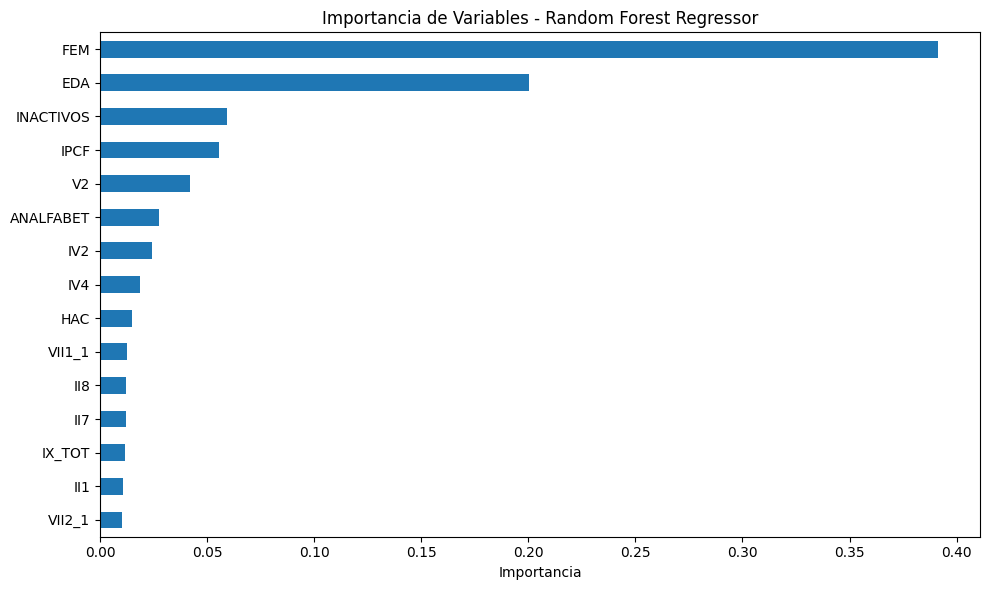

In [10]:
# --------------------------------------------
# Importancia de variables en Random Forest Regressor
# --------------------------------------------

# Crear DataFrame de importancias
importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Ordenar de mayor a menor
importances_sorted = importances.sort_values(ascending=False)

# Mostrar las 15 variables más importantes
print("\nTop 15 variables más importantes para predecir NE (Random Forest):")
print(importances_sorted.head(15))

# Gráfico de barras
plt.figure(figsize=(10, 6))
importances_sorted.head(15).plot(kind='barh')
plt.title("Importancia de Variables - Random Forest Regressor")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###4.3 Support Vector Regressor (SVR)

In [11]:
# -------------------------------
# 7. Support Vector Regressor (SVR)
# -------------------------------

# Crear pipeline con estandarización
svr_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

# Ajustar el modelo
svr_model.fit(X_train, y_train)

# Predecir sobre el test set
y_pred_svr = svr_model.predict(X_test)

# Evaluar desempeño
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

# Agregar resultados a la tabla
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'SVR', 'R2': r2_svr, 'RMSE': rmse_svr}])
], ignore_index=True)

# Mostrar resultados actualizados
print("\nResultados incluyendo SVR:")
print(df_resultados)



Resultados incluyendo SVR:
         Modelo        R2      RMSE
0         Lasso  0.391988  0.184350
1         Ridge  0.392089  0.184335
2    ElasticNet  0.391950  0.184356
3  RandomForest  0.679684  0.133807
4           SVR  0.442226  0.176570


##5. Clasificacion
$${PE}_i = \mathbb{I}({NE}_i<\tau)$$

$\tau$: Mediana

###5.1 Bosques aleatorios

In [12]:
# -------------------------------
# 1. Crear variable PE (por debajo de la mediana)
# -------------------------------
tau = df_modelo['NE'].median()
df_modelo['PE'] = (df_modelo['NE'] < tau).astype(int)

# -------------------------------
# 2. Preparar X e y
# -------------------------------
excluded_cols_clasif = [
    'NE', 'PE', 'PONDERA', 'PONDIH', 'EDA_sum', 'FEM_sum',
    'ANALFABET_sum', 'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum'
]
X = df_modelo.drop(columns=excluded_cols_clasif, errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df_modelo['PE']

# -------------------------------
# 3. División entrenamiento / test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# -------------------------------
# 4. Ajuste con GridSearchCV - Random Forest Classifier
# -------------------------------

# Definir rejilla de hiperparámetros
#param_grid = {
#    'n_estimators': [100, 200],
#    'max_depth': [None, 10, 20],
#    'min_samples_split': [2, 5],
#    'min_samples_leaf': [1, 2],
#    'max_features': ['sqrt', 'log2']
#}

param_grid = {
    'n_estimators': [100],         # fijo
    'max_depth': [10, 20],         # 2 valores
    'min_samples_split': [2],      # fijo
    'min_samples_leaf': [1, 2],    # 2 valores
    'max_features': ['sqrt']       # fijo
}


# Clasificador base
rf_clf_base = RandomForestClassifier(random_state=0)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar búsqueda
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf_clf = grid_search.best_estimator_

# -------------------------------
# 5. Evaluación del mejor modelo
# -------------------------------
y_pred_best = best_rf_clf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_mat_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

# Mostrar resultados
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"\nExactitud (Accuracy): {accuracy_best:.4f}")
print("\nMatriz de Confusión:")
print(conf_mat_best)
print("\nReporte de Clasificación:")
print(report_best)


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores hiperparámetros encontrados:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Exactitud (Accuracy): 0.7195

Matriz de Confusión:
[[1500  562]
 [ 563 1385]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2062
           1       0.71      0.71      0.71      1948

    accuracy                           0.72      4010
   macro avg       0.72      0.72      0.72      4010
weighted avg       0.72      0.72      0.72      4010




Top 15 variables más importantes para predecir PE (Random Forest Classifier):
EDA          0.168755
IPCF         0.115060
V2           0.074040
FEM          0.060315
INACTIVOS    0.052568
IV4          0.043252
HAC          0.038845
IV2          0.037552
IX_TOT       0.033944
II1          0.030627
II7          0.028648
VII2_1       0.028201
II8          0.025291
VII1_1       0.024369
ANALFABET    0.022192
dtype: float64


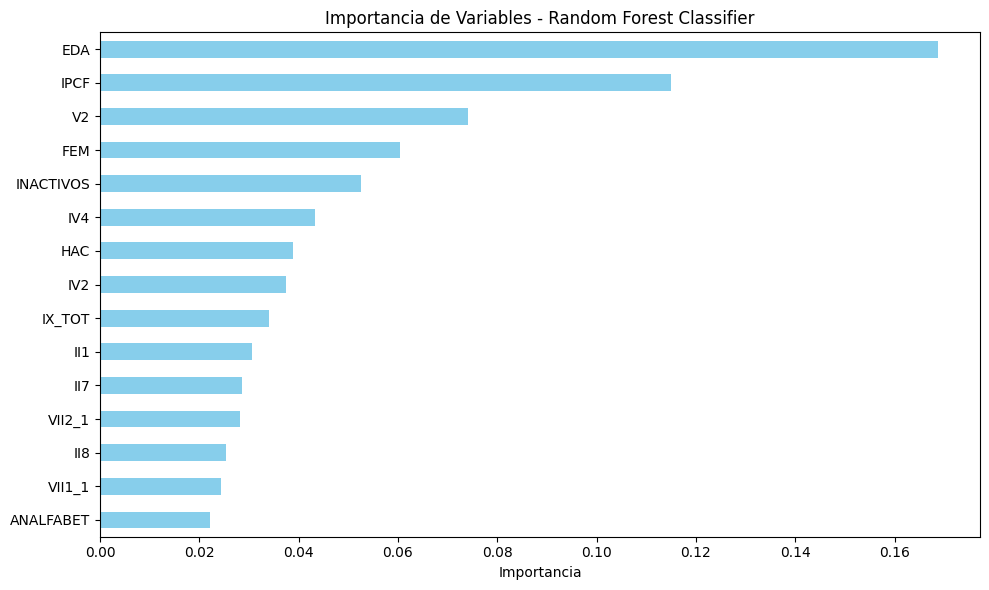

In [13]:
# --------------------------------------------
# Importancia de variables en Random Forest Classifier (clasificación)
# --------------------------------------------

# Crear DataFrame de importancias
importances_clf = pd.Series(best_rf_clf.feature_importances_, index=X.columns)

# Ordenar de mayor a menor
importances_clf_sorted = importances_clf.sort_values(ascending=False)

# Mostrar las 15 variables más importantes
print("\nTop 15 variables más importantes para predecir PE (Random Forest Classifier):")
print(importances_clf_sorted.head(15))

# Gráfico de barras
plt.figure(figsize=(10, 6))
importances_clf_sorted.head(15).plot(kind='barh', color='skyblue')
plt.title("Importancia de Variables - Random Forest Classifier")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###5.2 Support Vector Machine (SVM)

In [14]:
# -------------------------------
# SVM - Support Vector Machine (clasificación)
# -------------------------------

# Crear pipeline con estandarización
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0))

# Ajustar modelo
svm_model.fit(X_train, y_train)

# Predecir
y_pred_svm = svm_model.predict(X_test)

# Evaluar desempeño
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# Mostrar resultados
print(f"Exactitud (Accuracy) SVM: {accuracy_svm:.4f}")
print("\nMatriz de Confusión (SVM):")
print(conf_mat_svm)
print("\nReporte de Clasificación (SVM):")
print(report_svm)

Exactitud (Accuracy) SVM: 0.7080

Matriz de Confusión (SVM):
[[1474  588]
 [ 583 1365]]

Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2062
           1       0.70      0.70      0.70      1948

    accuracy                           0.71      4010
   macro avg       0.71      0.71      0.71      4010
weighted avg       0.71      0.71      0.71      4010

